# Counting Crowds with Deep Learning
## Proof Of Concept

The notebook will implement various papers for the puprose of crowd counting
* [Dense Scale Networks](https://arxiv.org/pdf/1906.09707.pdf)
* [CSRNet: Dilated Convolutional Neural Networks](https://arxiv.org/pdf/1802.10062.pdf)

The goal - to find the best approach to teach a model to count crowds, based on input images.

## 1. Imports

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import scipy.io
import h5py
import collections
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from skimage import exposure, img_as_float
import logging
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reporting module
from ovreport.report import report_to_overwatch

### 1.1 Globals
A number of parameters on top of the notebook

In [17]:
# Dataset Paths
train_path_UCF_QNRF = 'training_dataset/UCF-QNRF_ECCV18/Train_h5/'
test_path_UCF_QNRF = 'training_dataset/UCF-QNRF_ECCV18/Test_h5/'
train_path_SGH = 'training_dataset/ShanghaiTech/train_h5/'
test_path_SGH = 'training_dataset/ShanghaiTech/test_h5/'
# TODO: Add More ... add more

# Target Image Size
TARGET_SHAPE = (720, 480)
# Image Augmentation
IMG_AUG = True


# Model save paths
BEST_MODEL_SAVE_PATH = 'models/best/'
CKP_MODEL_SAVE_PATH = 'models/checkpoints/'
# Training Details
PRETRAINED_BACKBONE = True
TRAIN_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1
EPOCHS = 5
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 5e-4

### 1.2 Dealing with Data

In [18]:
class RawDataset(Dataset):
    def __init__(self, root, transform, ratio=8, output_shape=False, aug=False):
        self.nsamples = len(root)
        self.aug = aug
        self.output_shape = output_shape
        self.root = root
        self.ratio = ratio
        self.transform = transform
    
    def __augment(self, image, target, count, seed):
        random.seed(seed)
        
        # apply random crop
        if random.random() < 0.5:
            crop_size = (img.size[0]//2, img.size[1]//2)
        
            if random.random() <=0.44:
                # 4 non-overlapping patches
                dx = int(random.randint(0,1) * crop_size[0])
                dy = int(random.randint(0,1) * crop_size[1])
            else:
                # 5 random patches
                # set seed to ensure for each image the random patches are certain
                # if not set, the crop will be online which means the patches change every time loading, leading to a dynamic training set.
                patch_id = random.randint(0, 4)
                random.seed(index + patch_id * 0.1)
                dx = int(random.random() * crop_size[0])
                random.seed(index + 0.5 + patch_id * 0.1)
                dy = int(random.random() * crop_size[1])
            # crop
            img = img.crop((dx, dy, crop_size[0]+dx, crop_size[1]+dy))
            target = target[dy:crop_size[1]+dy, dx:crop_size[0]+dx]
            count = float(target.sum())
        
        if random.random() > 0.5:
            target = np.fliplr(target)
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        
        if random.random() > 0.7:
            img = img_as_float(image)
            # gamma_img: np.array(dtype=float64) ranging [0,1]
            if random.random() > 0.5:
                gamma_img = exposure.adjust_gamma(img, 1.5)
            else:
                gamma_img = exposure.adjust_gamma(img, 0.5)
            gamma_img = gamma_img * 255
            gamma_img = np.uint8(gamma_img)
            image = Image.fromarray(gamma_img)
        
        return image, target, count
    
    def __resize_to_target(self, img, target_shape):
        return cv2.resize(img, target_shape, interpolation=cv2.INTER_CUBIC)
    
    def __load_data(self, path, ratio=8, output_shape=None, aug=False, index=None):
        src_h5 = h5py.File(path, 'r')
        img = src_h5['image_array'].value
        output = src_h5['density_map'].value
        count = float(src_h5['count'].value)


        if len(img.shape) < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        if output_shape is not None:
            img = self.__resize_to_target(img, output_shape)
            output = self.__resize_to_target(output, output_shape)

        if aug:
            # TODO: Implement augumentation
            img, output, count = self.__augment(img, output, count, 42)

        if self.ratio>1:
            output = cv2.resize(output, 
                                (int(output.shape[1]/ratio),int(output.shape[0]/ratio)), 
                                interpolation=cv2.INTER_CUBIC) * (ratio**2)

        output = np.reshape(output, (1, ) + output.shape)

        return img, output, count        
    
    def __getitem__(self, index):
        img, target, count = self.__load_data(self.root[index], output_shape=self.output_shape, aug=self.aug)
        if self.transform:
            img = self.transform(img)
        return img, target, count
    
    def __len__(self):
        return self.nsamples

In [19]:
def get_loaders(train_path, test_path, output_shape, ratio=8):
    train_img_paths = glob.glob(os.path.join(train_path, '*.h5'))
    test_img_paths = glob.glob(os.path.join(test_path, '*.h5'))
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    train_dataset = RawDataset(train_img_paths, 
                               transform, 
                               ratio=ratio, 
                               output_shape=output_shape, 
                               aug=IMG_AUG)
    test_dataset = RawDataset(test_img_paths, 
                              transform, 
                              ratio=ratio, 
                              output_shape=output_shape, 
                              aug=IMG_AUG)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=TEST_BATCH_SIZE)
    
    return train_loader, test_loader

In [20]:
train_loader, test_loader = get_loaders(train_path_SGH, test_path_SGH, output_shape=TARGET_SHAPE)
train_loader2, test_loader2 = get_loaders(train_path_SGH, test_path_SGH, output_shape=TARGET_SHAPE, ratio=1)

In [21]:
train_loader_ucf, test_loader_ucf = get_loaders(train_path_UCF_QNRF, test_path_UCF_QNRF, output_shape=TARGET_SHAPE)
train_loader2_ucf, test_loader2_ucf = get_loaders(train_path_UCF_QNRF, test_path_UCF_QNRF, output_shape=TARGET_SHAPE, ratio=1)

#### 1.2.1 A common loader

In [22]:
def get_combined_loader(train_paths, test_paths, output_shape, ratio=8):
    train_img_paths = []
    test_img_paths = []
    
    for key in train_paths:
        res = glob.glob(os.path.join(train_paths[key], '*.h5'))
        train_img_paths += res
    
    for key in test_paths:
        res = glob.glob(os.path.join(test_paths[key], '*.h5'))
        test_img_paths += res
    
    
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    train_dataset = RawDataset(train_img_paths, 
                               transform, 
                               ratio=ratio, 
                               output_shape=output_shape, 
                               aug=IMG_AUG)
    test_dataset = RawDataset(test_img_paths, 
                              transform, 
                              ratio=ratio, 
                              output_shape=output_shape, 
                              aug=IMG_AUG)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=TEST_BATCH_SIZE)
    
    return train_loader, test_loader 

In [23]:
dataset = {
    'train': {
         'sgh': train_path_SGH,
         'ucf': train_path_UCF_QNRF
    },
    'test': {
        'sgh': test_path_SGH,
        'ucf': test_path_UCF_QNRF
    }
}

In [24]:
train_cmb_loader, test_cmb_loader = get_combined_loader(dataset['train'], dataset['test'], output_shape=TARGET_SHAPE)
train_cmb_loader_csr, test_cmb_loader_csr = get_combined_loader(dataset['train'], dataset['test'], output_shape=TARGET_SHAPE,
                                                                ratio=1)

### 1.3 Utilities

#### 1.3.1 Model Checkpoints
Save model checkpoints, which are - epoch number, model state and optimizer state. A model checkpoint will be saved only whenever a better MAE is achieved or each 5 epochs, only if the previous loss has been improved.

In [25]:
def save_checkpoint(epoch, model_filename, model_state_dict, optimizer_state_dict, save_path):
    '''
        Saves the model, as well as the optimizer state in the predefined place.
    '''
    print('Saving Model!')
    state = {
        'epoch': epoch,
        'state_dict': model_state_dict,
        'optimizer': optimizer_state_dict
    }
    
    torch.save(state, os.path.join(save_path, model_filename))

In [26]:
def load_checkpoint(checkpoint_filepath, model, optimizer):
    '''
        Loads the model from checkpoint_filepath.
    '''    
    state = torch.load(checkpoint_filepath)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    epoch = state['epoch']
    return epoch, model, optimizer

## 2. Dense Scale Network

### 2.1 The Model

In [43]:
class DDCB(nn.Module):
    '''
        TODO: Docstring
    '''
    def __init__(self, in_planes):
        super(DDCB, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, 256, 1), nn.ReLU(True), 
                                   nn.Conv2d(256, 64, 3, padding=1), nn.ReLU(True))
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes+64, 256, 1), nn.ReLU(True), 
                                   nn.Conv2d(256, 64, 3, padding=2, dilation=2), nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(in_planes+128, 256, 1), nn.ReLU(True), 
                                   nn.Conv2d(256, 64, 3, padding=3, dilation=3), nn.ReLU(True))
        self.conv4 = nn.Sequential(nn.Conv2d(in_planes+128, 512, 3, padding=1), nn.ReLU(True))
    def forward(self, x):
        x1_raw = self.conv1(x)
        x1 = torch.cat([x, x1_raw], 1)
        x2_raw = self.conv2(x1)
        x2 = torch.cat([x, x1_raw, x2_raw], 1)
        x3_raw = self.conv3(x2)
        x3 = torch.cat([x, x2_raw, x3_raw], 1)
        output = self.conv4(x3)
        return output

In [44]:
class DenseScaleNet(nn.Module):
    '''
        TODO: Docstring
    '''
    def __init__(self, model_state='', pretrained_backbone=False, trainable_backbone=False):
        super(DenseScaleNet, self).__init__()
        self.model_state = model_state
        self.pretrained_backbone = pretrained_backbone
        self.trainable_backbone = trainable_backbone
        # network
        self.features = self.__get_backbone()
        self.DDCB1 = DDCB(512)
        self.DDCB2 = DDCB(512)
        self.DDCB3 = DDCB(512)
        self.output_layers = nn.Sequential(nn.Conv2d(512, 128, 3, padding=1), 
                                           nn.ReLU(True), 
                                           nn.Conv2d(128, 64, 3, padding=1), 
                                           nn.ReLU(True), 
                                           nn.Conv2d(64, 1, 1))
        self.__initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x1_raw = self.DDCB1(x)
        x1 = x1_raw + x
        x2_raw = self.DDCB2(x1)
        x2 = x2_raw + x1_raw + x
        x3_raw = self.DDCB3(x2)
        x3 = x3_raw + x2_raw + x1_raw + x
        output = self.output_layers(x3)
        return output
    
    def __get_backbone(self):
        self.features_cfg = [64, 64, 'M', 
                             128, 128, 'M', 
                             256, 256, 256, 'M', 
                             512, 512, 512,]
        return self.__make_layers(self.features_cfg, batch_norm=True)
    
    def __make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=False):
        if dilation:
            d_rate = 2
        else:
            d_rate = 1
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)   
    
    def __initialize_weights(self):
        self_dict = self.state_dict()
        pretrained_dict = dict()
        self.__random_initialize_weights()
        if not self.model_state:
            # load vgg16
            vgg16 = torchvision.models.vgg16(pretrained=self.pretrained_backbone)
            # check if the backbone should be trainable or not
            if not self.trainable_backbone:
                for param in vgg16.parameters():
                    param.requires_grad = False
            # copy over the items that match        
            for k, v in vgg16.state_dict().items():
                if k in self_dict and self_dict[k].size() == v.size():
                    pretrained_dict[k] = v
            self_dict.update(pretrained_dict)
            self.load_state_dict(self_dict)
        else:
            self_dict.update(self.model_state)
            self.load_state_dict(self_dict)
            
    def __random_initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, std=0.01)
                #nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

### 2.2 Criterion, Loss

In [45]:
criterion = nn.MSELoss()

In [46]:
def cal_lc_loss(output, target, sizes=(1,2,4)):
    criterion_L1 = nn.L1Loss()
    Lc_loss = None
    for s in sizes:
        pool = nn.AdaptiveAvgPool2d(s)
        est = pool(output)
        gt = pool(target)
        if Lc_loss:
            Lc_loss += criterion_L1(est, gt)
        else:
            Lc_loss = criterion_L1(est, gt)
    return Lc_loss

In [47]:
def calc_loss(output, target):
    Le_Loss = criterion(output, target)
    Lc_Loss = cal_lc_loss(output, target)
    loss = Le_Loss + 1000 * Lc_Loss
    return loss

In [48]:
def val(model, test_loader):
    model.eval()
    mae = 0.0
    mse = 0.0
    with torch.no_grad():
        for img, target, count in test_loader:
            img = img.cuda()
            output = model(img)
            est_count = output.sum().item()
            mae += abs(est_count - count)
            mse += (est_count - count)**2
    mae /= len(test_loader)
    mse /= len(test_loader)
    mse = mse**0.5
    return float(mae), float(mse)

### 2.3 Init Model

In [16]:
dsn_net = DenseScaleNet('', pretrained_backbone=True, trainable_backbone=False)
dsn_net.cuda()

DenseScaleNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2

### 2.4 Optimizer

In [17]:
optimizer = torch.optim.Adam(dsn_net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### 2.5 Training Loop

In [18]:
def train_model(model, optimizer, train_loader, test_loader, 
                resume_training=False, saved_model_filepath=''):
    '''
        TODO: Docstring
    '''
    init_epoch = 0
    if resume_training:
        init_epoch, model, optimizer = load_checkpoint(saved_model_filepath, model, optimizer)
    
    
    best_mae, _  = val(model, test_loader)
    
    for epoch in range(init_epoch, EPOCHS+init_epoch):
        train_loss = 0.0
        model.train()
        for img, target, count in tqdm(train_loader):
            optimizer.zero_grad()
            img = img.cuda()
            target = target.float()
            target = target.cuda()
            output = model(img)

            loss = calc_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        mae, mse = val(model, test_loader)

        print('Epoch {}/{} Loss:{:.3f}, MAE:{:.2f}, MSE:{:.2f}, Best MAE:{:.2f}'.format(epoch+1, 
                                                                                        EPOCHS+init_epoch, 
                                                                                        train_loss/len(train_loader), 
                                                                                        mae, 
                                                                                        mse, 
                                                                                        best_mae))
        if (epoch + 1) % 5 == 0:
            save_checkpoint(epoch, f'DenseScaleNet_aug_e{epoch+1}_{LEARNING_RATE}.pth', 
                            model.state_dict(), 
                            optimizer.state_dict(), 
                            CKP_MODEL_SAVE_PATH)          
        
        if mae < best_mae:
            best_mae = mae
            print(f'New best mae: {best_mae}. Saving model!')
            # report best model
            report_to_overwatch('PH:ML:P', 'Atlas', f'Epoch {epoch+1} recorded {best_mae}!')
            
            save_checkpoint(epoch, f'DenseScaleNet_aug_e{epoch+1}_{LEARNING_RATE}.pth', 
                            model.state_dict(), 
                            optimizer.state_dict(), 
                            BEST_MODEL_SAVE_PATH)
    
    return model

### 2.6 Training the model

In [ ]:
dsn_net = train_model(dsn_net, optimizer, train_loader, test_loader, resume_training=True, 
                     saved_model_filepath='models/checkpoints/DenseScaleNet_aug_e94_1e-05.pth')
report_to_overwatch('PH:ML:P', 'Atlas', 'Training of model done!')

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 96/114 Loss:12.522, MAE:125.35, MSE:198.53, Best MAE:105.58


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 97/114 Loss:11.057, MAE:122.84, MSE:196.88, Best MAE:105.58


 88%|████████▊ | 353/400 [01:53<00:15,  3.11it/s]

### 2.7 Testing

As the model was trained on the ShanghaiTech dataset it will evaluated on the UCF-QNRF dataset, as well as on a single SGH sample.

In [19]:
# load the model
epoch, dsn_net, optimizer = load_checkpoint('models/best/DenseScaleNet_aug_e94_1e-05.pth', 
                                            dsn_net, 
                                           optimizer)

In [20]:
maesgh, msesgh = val(dsn_net, test_loader)
maeucf, mseucf = val(dsn_net, test_loader_ucf)

In [21]:
print(f'SGH: MAE->{maesgh}; MSE->{msesgh}')
print(f'UCF: MAE->{maeucf}; MSE->{mseucf}')

SGH: MAE->102.12059513375729; MSE->168.31945353503326
UCF: MAE->423.5519723958241; MSE->682.4308837002275


In [23]:
src_h5 = h5py.File('training_dataset/ShanghaiTech/test_h5/train_h5GT_IMG_313.mat.h5', 'r')
img = src_h5['image_array'].value
output = src_h5['density_map'].value
count = float(src_h5['count'].value)

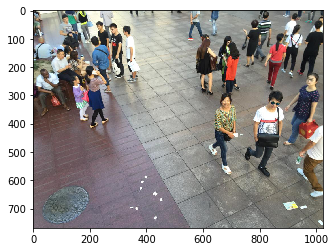

In [25]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [26]:
img = cv2.resize(img, (720, 480), interpolation=cv2.INTER_CUBIC)
img = np.reshape(img, (1, 3, 480, 720))
timg = torch.from_numpy(img).float().cuda()

In [27]:
output = dsn_net(timg)

In [28]:
output.sum().item()

330278.25

In [29]:
count

29.0

## 3. Congested Scene Recognition Network

### 3.1 The Model

In [50]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False, trainable_backbone=False):
        super(CSRNet, self).__init__()
        self.trainable_backbone = trainable_backbone
        self.frontend_feat = [64, 64, 'M', 128, 128,
                              'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = self.__make_layers(self.frontend_feat, batch_norm=True)
        self.backend = self.__make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        self.__initialize_weights()

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        x = nn.functional.interpolate(x, scale_factor=8)
        return x

    def __initialize_weights(self):
        self_dict = self.state_dict()
        pretrained_dict = dict()
        # load vgg16
        vgg16 = torchvision.models.vgg16(pretrained=True)
        # check if the backbone should be trainable or not
        if self.trainable_backbone:
            for param in vgg16.parameters():
                param.requires_grad = False
        # copy over the items that match        
        for k, v in vgg16.state_dict().items():
            if k in self_dict and self_dict[k].size() == v.size():
                pretrained_dict[k] = v
        self_dict.update(pretrained_dict)
        self.load_state_dict(self_dict)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
    def __make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=False):
        if dilation:
            d_rate = 2
        else:
            d_rate = 1
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3,
                                   padding=d_rate, dilation=d_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

### 3.2 Criterion / Loss
Same as Dense Scale Net

In [51]:
criterion = nn.MSELoss(size_average=False)

In [52]:
def csr_loss(model, test_dataloader):
    epoch_mae = 0
    for img, target, count in test_dataloader:
        image = img.cuda()
        target = target.float()
        gt_densitymap = target.cuda()
        et_densitymap = model(image).detach()           # forward propagation
        mae = abs(et_densitymap.data.sum()-gt_densitymap.data.sum())
        epoch_mae += mae.item()
    
    epoch_mae /= len(test_dataloader)
    
    return epoch_mae

### 3.3 Init Model

In [14]:
csr_net = CSRNet()
csr_net.cuda()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 

### 3.4 Optimizer

In [15]:
optimizer = torch.optim.Adam(csr_net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) 

### 3.5 Train Loop

In [18]:
def train_model(model, optimizer, criterion, train_dataloader, test_dataloader, saved_model_filepath=''):
    min_mae = 999999
    min_mae_epoch = -1
    init_epoch = 0
    if saved_model_filepath != '':
        init_epoch, model, optimizer = load_checkpoint(saved_model_filepath, model, optimizer)
        min_mae = csr_loss(model, test_dataloader)
        min_mae_epoch = init_epoch
        print(f'MAE to beat:{min_mae} recorded at {min_mae_epoch}')
    
    for epoch in range(init_epoch, init_epoch+EPOCHS):                          # start training
        model.train()
        epoch_loss = 0.0
        for img, target, count in tqdm(train_dataloader):
            image = img.cuda()
            gt_densitymap = target.float()
            gt_densitymap = gt_densitymap.cuda()
            et_densitymap = model(image)  
            loss = criterion(et_densitymap,gt_densitymap)       # calculate loss
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()                                     # back propagation
            optimizer.step()                                    # update network parameters
            
        print('Epoch {}/{} Loss: {:.3f}'.format(epoch+1, init_epoch+EPOCHS, epoch_loss/len(train_loader)))

        model.eval()
        
        with torch.no_grad():
            epoch_mae = 0.0
            for img, target, count in test_dataloader:
                image = img.cuda()
                target = target.float()
                gt_densitymap = target.cuda()
                et_densitymap = model(image).detach()           # forward propagation
                mae = abs(et_densitymap.data.sum() - gt_densitymap.data.sum())
                epoch_mae += mae.item()
            epoch_mae /= len(test_dataloader)
            print('Epoch {}/{} MAE: {:.3f}'.format(epoch+1, init_epoch+EPOCHS, epoch_mae))
            if epoch_mae < min_mae:
                min_mae, min_mae_epoch = epoch_mae, epoch
                report_to_overwatch('PH:ML:P', 'Atlas', f'Epoch {epoch+1} recorded {min_mae}!')

                save_checkpoint(epoch, 'CSRNet_aug_e'+str(epoch+1)+".pth", 
                                model.state_dict(), 
                                optimizer.state_dict(), 
                                BEST_MODEL_SAVE_PATH)                

    return model

### 3.6 Training the model.

In [19]:
csr_net = train_model(csr_net, optimizer, criterion, train_cmb_loader_csr, test_cmb_loader_csr, 
                      saved_model_filepath='models/best/CSRNet_no_aug_e30.pth')
report_to_overwatch('PH:ML:P', 'Atlas', 'Training of CSRNet model done!')

  0%|          | 1/1601 [00:00<04:03,  6.56it/s]

MAE to beat:78.8140633216271 recorded at 29


100%|██████████| 1601/1601 [28:45<00:00,  1.08s/it]


Epoch 30/34 Loss: 4.415


  0%|          | 1/1601 [00:00<03:17,  8.08it/s]

Epoch 30/34 MAE: 109.096


100%|██████████| 1601/1601 [28:37<00:00,  1.07s/it]


Epoch 31/34 Loss: 4.466


  0%|          | 1/1601 [00:00<03:48,  6.99it/s]

Epoch 31/34 MAE: 105.494


100%|██████████| 1601/1601 [28:38<00:00,  1.07s/it]


Epoch 32/34 Loss: 4.463


  0%|          | 1/1601 [00:00<05:04,  5.25it/s]

Epoch 32/34 MAE: 107.212


100%|██████████| 1601/1601 [28:37<00:00,  1.07s/it]


Epoch 33/34 Loss: 4.340


  0%|          | 1/1601 [00:00<04:36,  5.79it/s]

Epoch 33/34 MAE: 199.873


100%|██████████| 1601/1601 [28:47<00:00,  1.08s/it]


Epoch 34/34 Loss: 4.832
Epoch 34/34 MAE: 94.225
200
Report sent


### 3.7 Testing

In [27]:
epoch, csr_net, optimizer = load_checkpoint('models/best/CSRNet_aug_e130.pth', 
                                            csr_net, 
                                            optimizer)

In [28]:
mae_sgh = csr_loss(csr_net, test_loader2)
mae_ucf = csr_loss(csr_net, test_loader2_ucf)
print(f'SGH: {mae_sgh}; UCF: {mae_ucf}')

SGH: 47.59450504146045; UCF: 215.64305806873801


#### 3.7.1 ShanghaiTech Single Image Example

In [38]:
src_h5 = h5py.File('training_dataset/ShanghaiTech/test_h5/train_h5GT_IMG_23.mat.h5', 'r')
img = src_h5['image_array'].value
output = src_h5['density_map'].value
count = float(src_h5['count'].value)

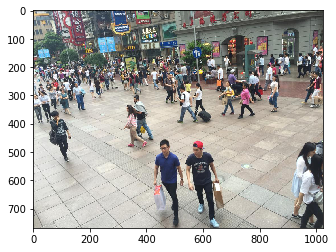

In [39]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [40]:
img = cv2.resize(img, (720, 480), interpolation=cv2.INTER_CUBIC)
img = np.reshape(img, (1, 3, 480, 720))
timg = torch.from_numpy(img).float().cuda()
out = csr_net(timg)
out.sum().item()

641.2296752929688

In [41]:
count

240.0

#### 3.7.2 UCF-QNRF Single Image Example

In [34]:
src_h5 = h5py.File('training_dataset/UCF-QNRF_ECCV18/Test_h5/img_0016.h5', 'r')
img = src_h5['image_array'].value
output = src_h5['density_map'].value
count = float(src_h5['count'].value)

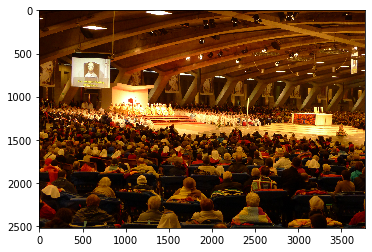

In [35]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [36]:
img = cv2.resize(img, (720, 480), interpolation=cv2.INTER_CUBIC)
img = np.reshape(img, (1, 3, 480, 720))
timg = torch.from_numpy(img).float().cuda()
out = csr_net(timg)
out.sum().item()

603.9884033203125

In [37]:
count

853.0

## 4. Testing The Algorithms

### 4.0 The Records Dataset

In [65]:
import pandas as pd
from datetime import datetime as dt

if os.path.exists('models/model_perf.csv'):
    records_df = pd.read_csv('models/model_perf.csv')
else:
    records_df = pd.DataFrame(columns=['date', 'model_name', 'filepath', 'Dataset', 'Learning_Rate', 'Weight_Decay', 'MAE', 'MSE'])

### 4.1 Evaluate the Dense Scale Model

In [66]:
dsn_net = DenseScaleNet('', pretrained_backbone=True, trainable_backbone=False)
dsn_net.cuda()
opt_dsn = torch.optim.Adam(dsn_net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# load the model
model_filepath = 'models/best/DenseScaleNet_aug_e94_1e-05.pth'
_, dsn_net, _ = load_checkpoint(model_filepath, 
                                 dsn_net, 
                                 opt_dsn)

#### Evaluate

In [67]:
dsn_maesgh, dsn_msesgh = val(dsn_net, test_loader)
dsn_maeucf, dsn_mseucf = val(dsn_net, test_loader_ucf)
dsn_maecmb, dsn_msecmb = val(dsn_net, test_cmb_loader)

#### Record

In [68]:
last_index = len(records_df)
records_df.loc[last_index] = [dt.now().strftime("%Y-%m-%d %H"),
                              'DSN',
                              model_filepath,
                              'ShanghaiTech',
                              LEARNING_RATE,
                              WEIGHT_DECAY,
                              dsn_maesgh,
                              dsn_msesgh
                             ]
records_df.loc[last_index+1] = [dt.now().strftime("%Y-%m-%d %H"),
                                'DSN',
                                model_filepath,
                                'UCF-QNRF',
                                LEARNING_RATE,
                                WEIGHT_DECAY,
                                dsn_maeucf,
                                dsn_mseucf
                                ]
records_df.loc[last_index+2] = [dt.now().strftime("%Y-%m-%d %H"),
                                'DSN',
                                model_filepath,
                                'Combined',
                                LEARNING_RATE,
                                WEIGHT_DECAY,
                                dsn_maecmb,
                                dsn_msecmb
                                ]

In [70]:
records_df.to_csv('models/model_perf.csv')

### 4.2 The Congested Scene Recognition

In [53]:
model_filepath = 'models/best/CSRNet_aug_e130.pth'
csr_net = CSRNet()
csr_net.cuda()
_, csr_net, _ = load_checkpoint(model_filepath, 
                                csr_net, 
                                optimizer)

#### Evaluate

In [71]:
mae_sgh = csr_loss(csr_net, test_loader2)
mae_ucf = csr_loss(csr_net, test_loader2_ucf)
mae_cmb = csr_loss(csr_net, test_cmb_loader_csr)

#### Record

In [76]:
last_index = len(records_df)
records_df.loc[last_index] = [dt.now().strftime("%Y-%m-%d %H"),
                              'CSR',
                              model_filepath,
                              'ShanghaiTech',
                              LEARNING_RATE,
                              WEIGHT_DECAY,
                              mae_sgh,
                              0
                             ]
records_df.loc[last_index+1] = [dt.now().strftime("%Y-%m-%d %H"),
                                'CSR',
                                model_filepath,
                                'UCF-QNRF',
                                LEARNING_RATE,
                                WEIGHT_DECAY,
                                mae_ucf,
                                0
                                ]
records_df.loc[last_index+2] = [dt.now().strftime("%Y-%m-%d %H"),
                                'CSR',
                                model_filepath,
                                'Combined',
                                LEARNING_RATE,
                                WEIGHT_DECAY,
                                mae_cmb,
                                0
                                ]

In [77]:
records_df.to_csv('models/model_perf.csv')

### 4.3 Displaing results

In [78]:
records_df

,date,model_name,filepath,Dataset,Learning_Rate,Weight_Decay,MAE,MSE
0,2020-04-06 20,DSN,models/best/DenseScaleNet_aug_e94_1e-05.pth,ShanghaiTech,0.00001,0.0005,102.120595,168.319454
1,2020-04-06 20,DSN,models/best/DenseScaleNet_aug_e94_1e-05.pth,UCF-QNRF,0.00001,0.0005,423.551972,682.430884
2,2020-04-06 20,DSN,models/best/DenseScaleNet_aug_e94_1e-05.pth,Combined,0.00001,0.0005,267.286872,503.068298
3,2020-04-06 20,CSR,models/best/DenseScaleNet_aug_e94_1e-05.pth,ShanghaiTech,0.00001,0.0005,47.594505,0.000000
4,2020-04-06 20,CSR,models/best/DenseScaleNet_aug_e94_1e-05.pth,UCF-QNRF,0.00001,0.0005,215.643058,0.000000
5,2020-04-06 20,CSR,models/best/DenseScaleNet_aug_e94_1e-05.pth,Combined,0.00001,0.0005,133.945608,0.000000
